In [4]:
import pandas as pd

In [5]:
# check if on colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# if on colab, install scikit-learn==1.2.2 and xgboost==1.7.6
if IN_COLAB:
    !pip uninstall scikit-learn -y
    !pip uninstall xgboost -y
    !pip install scikit-learn==1.2.2
    !pip install xgboost==1.7.6

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: xgboost 1.7.6
Uninstalling xgboost-1.7.6:
  Successfully uninstalled xgboost-1.7.6
  Using cached scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
  Using cached xgboost-1.7.6-py3-none-manylinux2014_x86_64.whl.metadata (1.9 kB)
Using cached xgboost-1.7.6-py3-none-manylinux2014_x86_64.whl (200.3 MB)


In [6]:
df_main = pd.read_csv("dataframes/incidenti_tfl_2019.csv")
df_ages = pd.read_csv("dataframes/age_range_counts_to_merge.csv")
df_vehicles = pd.read_csv("dataframes/vehicles_by_cat.csv")


In [7]:
print(df_main.keys())
df_main.head()

Index(['$type', 'id', 'lat', 'lon', 'location', 'date', 'severity', 'borough',
       'casualties', 'vehicles'],
      dtype='object')


,$type,id,lat,lon,location,date,severity,borough,casualties,vehicles
0,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345979,51.570865,-0.231959,On Edgware Road Near The Junction With north C...,2019-01-04T21:22:00Z,Slight,Barnet,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
1,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345980,51.603859,-0.187240,On Willow Way Near The Junction With Long Lane,2019-01-04T23:33:00Z,Slight,Barnet,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
2,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345981,51.512198,-0.153122,On north Audley Street Near The Junction With ...,2019-01-04T22:15:00Z,Slight,City of Westminster,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
3,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345982,51.431480,-0.016083,On Bromley Road Near The Junction With Daneswo...,2019-01-04T18:00:00Z,Slight,Lewisham,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
4,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345983,51.473487,0.145202,On Belmont Road Near The Junction With Bedonwe...,2019-01-04T20:45:00Z,Slight,Bexley,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...


```json
exmpl = {
    "$type": "Tfl.Api.Presentation.Entities.AccidentStats.AccidentDetail, Tfl.Api.Presentation.Entities",
    "id": 345979,
    "lat": 51.570865,
    "lon": -0.231959,
    "location": "On Edgware Road Near The Junction With north Circular Road",
    "date": "2019-01-04T21:22:00Z",
    "severity": "Slight",
    "borough": "Barnet",
    "casualties": [{
        "$type": "Tfl.Api.Presentation.Entities.AccidentStats.Casualty, Tfl.Api.Presentation.Entities",
        "age": 20,
        "class": "Driver",
        "severity": "Slight",
        "mode": "PoweredTwoWheeler",
        "ageBand": "Adult"
    }],
    "vehicles": [{
        "$type": "Tfl.Api.Presentation.Entities.AccidentStats.Vehicle, Tfl.Api.Presentation.Entities",
        "type": "Motorcycle_500cc_Plus"
    }, {
        "$type": "Tfl.Api.Presentation.Entities.AccidentStats.Vehicle, Tfl.Api.Presentation.Entities",
        "type": "Car"
    }]
}
```

In [8]:
# Dropped unecessary cols
# General idea keep: [id, lat, lon, date, TOD, severity, boroughs..., casualties_age_range..., num_vehicles_per_type...]
df_main.drop(columns=['$type', 'location', 'casualties', 'vehicles'], inplace=True)

In [9]:
# converting 'severity' to cardinal indicator
df_main['severity'] = df_main['severity'].map({'Slight': 0, 'Serious': 1, 'Fatal': 2})

In [10]:
# Encode boroughs to OHE
borough_encoded = pd.get_dummies(df_main['borough'], prefix='borough', dtype=int)
df_main = pd.concat([df_main, borough_encoded], axis=1)
df_main.drop('borough', axis=1, inplace=True)


Dividing time_of_day using pd.cut(). Here the intervals have a practical meaning, so pd.cut() is better than pd.qcut().

In [11]:
# Time of day Pre Processing
df_main['date'] = pd.to_datetime(df_main['date'])
# df_main['date'].dt.hour.plot.hist(bins=24, color='skyblue', edgecolor='black', alpha=0.7)
df_main['time_of_day'], bins = pd.cut(df_main['date'].dt.hour, bins=[0, 6, 12, 18, 24] , labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False, retbins=True)
print(bins)
df_main.head()

[ 0  6 12 18 24]


,id,lat,lon,date,severity,borough_Barking and Dagenham,borough_Barnet,borough_Bexley,borough_Brent,borough_Bromley,...,borough_Merton,borough_Newham,borough_Redbridge,borough_Richmond upon Thames,borough_Southwark,borough_Sutton,borough_Tower Hamlets,borough_Waltham Forest,borough_Wandsworth,time_of_day
0,345979,51.570865,-0.231959,2019-01-04 21:22:00+00:00,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Evening
1,345980,51.603859,-0.187240,2019-01-04 23:33:00+00:00,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Evening
2,345981,51.512198,-0.153122,2019-01-04 22:15:00+00:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Evening
3,345982,51.431480,-0.016083,2019-01-04 18:00:00+00:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Evening
4,345983,51.473487,0.145202,2019-01-04 20:45:00+00:00,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Evening


In [12]:
# Encode time_of_day to OHE
time_of_day_encoded = pd.get_dummies(df_main['time_of_day'], prefix='time_of_day', dtype=int)
df_main = pd.concat([df_main, time_of_day_encoded], axis=1)
df_main.drop('time_of_day', axis=1, inplace=True)
df_main.head()

,id,lat,lon,date,severity,borough_Barking and Dagenham,borough_Barnet,borough_Bexley,borough_Brent,borough_Bromley,...,borough_Richmond upon Thames,borough_Southwark,borough_Sutton,borough_Tower Hamlets,borough_Waltham Forest,borough_Wandsworth,time_of_day_Night,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening
0,345979,51.570865,-0.231959,2019-01-04 21:22:00+00:00,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,345980,51.603859,-0.187240,2019-01-04 23:33:00+00:00,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,345981,51.512198,-0.153122,2019-01-04 22:15:00+00:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,345982,51.431480,-0.016083,2019-01-04 18:00:00+00:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,345983,51.473487,0.145202,2019-01-04 20:45:00+00:00,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [13]:
df_main['month'] = df_main['date'].dt.month
df_main.head()

,id,lat,lon,date,severity,borough_Barking and Dagenham,borough_Barnet,borough_Bexley,borough_Brent,borough_Bromley,...,borough_Southwark,borough_Sutton,borough_Tower Hamlets,borough_Waltham Forest,borough_Wandsworth,time_of_day_Night,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening,month
0,345979,51.570865,-0.231959,2019-01-04 21:22:00+00:00,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,345980,51.603859,-0.187240,2019-01-04 23:33:00+00:00,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,345981,51.512198,-0.153122,2019-01-04 22:15:00+00:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,345982,51.431480,-0.016083,2019-01-04 18:00:00+00:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,345983,51.473487,0.145202,2019-01-04 20:45:00+00:00,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1


In [14]:
df_main['day_of_week'] = df_main['date'].dt.day_name()
df_main['day_of_week'] = df_main['day_of_week'].map({'Monday':0, 'Tuesday':1, 'Wednesday': 2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6})
df_main.head()

,id,lat,lon,date,severity,borough_Barking and Dagenham,borough_Barnet,borough_Bexley,borough_Brent,borough_Bromley,...,borough_Sutton,borough_Tower Hamlets,borough_Waltham Forest,borough_Wandsworth,time_of_day_Night,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening,month,day_of_week
0,345979,51.570865,-0.231959,2019-01-04 21:22:00+00:00,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,4
1,345980,51.603859,-0.187240,2019-01-04 23:33:00+00:00,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,4
2,345981,51.512198,-0.153122,2019-01-04 22:15:00+00:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,4
3,345982,51.431480,-0.016083,2019-01-04 18:00:00+00:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,4
4,345983,51.473487,0.145202,2019-01-04 20:45:00+00:00,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,4


In [15]:
# Each Dataframe comes through pre processing in its own file

# CASUALTIES_AG_RANGE
df_merged = df_main.merge(df_ages, on='id', how='left')


# NUM OG VEHICLES PER TYPE
df_merged = df_merged.merge(df_vehicles, on='id', how='left')


print(df_merged.keys())
df_merged.head()

Index(['id', 'lat', 'lon', 'date', 'severity', 'borough_Barking and Dagenham',
       'borough_Barnet', 'borough_Bexley', 'borough_Brent', 'borough_Bromley',
       'borough_Camden', 'borough_City of London',
       'borough_City of Westminster', 'borough_Croydon', 'borough_Ealing',
       'borough_Enfield', 'borough_Greenwich', 'borough_Hackney',
       'borough_Hammersmith and Fulham', 'borough_Haringey', 'borough_Harrow',
       'borough_Havering', 'borough_Hillingdon', 'borough_Hounslow',
       'borough_Islington', 'borough_Kensington and Chelsea',
       'borough_Kingston', 'borough_Lambeth', 'borough_Lewisham',
       'borough_Merton', 'borough_Newham', 'borough_Redbridge',
       'borough_Richmond upon Thames', 'borough_Southwark', 'borough_Sutton',
       'borough_Tower Hamlets', 'borough_Waltham Forest', 'borough_Wandsworth',
       'time_of_day_Night', 'time_of_day_Morning', 'time_of_day_Afternoon',
       'time_of_day_Evening', 'month', 'day_of_week', 'casualty_age_0-23',
 

,id,lat,lon,date,severity,borough_Barking and Dagenham,borough_Barnet,borough_Bexley,borough_Brent,borough_Bromley,...,casualty_age_0-23,casualty_age_24-30,casualty_age_31-38,casualty_age_39-50,casualty_age_50+,Car,Heavy_Vehicles,Motorcycle,Other,Pedalcycle
0,345979,51.570865,-0.231959,2019-01-04 21:22:00+00:00,0,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,0
1,345980,51.603859,-0.187240,2019-01-04 23:33:00+00:00,0,0,1,0,0,0,...,0,1,0,0,0,2,0,1,0,0
2,345981,51.512198,-0.153122,2019-01-04 22:15:00+00:00,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,345982,51.431480,-0.016083,2019-01-04 18:00:00+00:00,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
4,345983,51.473487,0.145202,2019-01-04 20:45:00+00:00,0,0,0,1,0,0,...,1,1,0,0,0,2,0,0,0,0


In [16]:
df_merged.to_csv('dataframes/merged_nov_29.csv', index=False)

In [17]:
df_merged.columns

Index(['id', 'lat', 'lon', 'date', 'severity', 'borough_Barking and Dagenham',
       'borough_Barnet', 'borough_Bexley', 'borough_Brent', 'borough_Bromley',
       'borough_Camden', 'borough_City of London',
       'borough_City of Westminster', 'borough_Croydon', 'borough_Ealing',
       'borough_Enfield', 'borough_Greenwich', 'borough_Hackney',
       'borough_Hammersmith and Fulham', 'borough_Haringey', 'borough_Harrow',
       'borough_Havering', 'borough_Hillingdon', 'borough_Hounslow',
       'borough_Islington', 'borough_Kensington and Chelsea',
       'borough_Kingston', 'borough_Lambeth', 'borough_Lewisham',
       'borough_Merton', 'borough_Newham', 'borough_Redbridge',
       'borough_Richmond upon Thames', 'borough_Southwark', 'borough_Sutton',
       'borough_Tower Hamlets', 'borough_Waltham Forest', 'borough_Wandsworth',
       'time_of_day_Night', 'time_of_day_Morning', 'time_of_day_Afternoon',
       'time_of_day_Evening', 'month', 'day_of_week', 'casualty_age_0-23',
 

Let's explore the target variable

<Axes: xlabel='severity'>

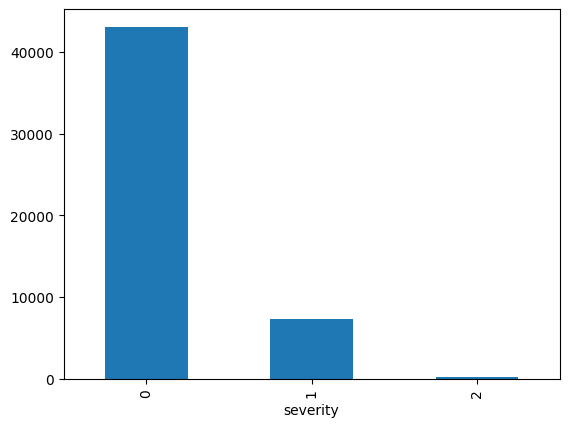

In [18]:
df_merged['severity'].value_counts().plot(kind='bar')


In [19]:
print(df_merged['severity'].value_counts())


severity
0    43060
1     7326
2      240
Name: count, dtype: int64


As we can see, the target variable is extremely imbalanced. When classifying we might wanna specify the 'class_weight' argument of the classifier, in order to soften the effect of the imbalance of the target class.

Computing the proportion of accidents (by severity) for each borough and time_of_day.

In [20]:
boroughs = ['borough_Barking and Dagenham',
       'borough_Barnet', 'borough_Bexley', 'borough_Brent', 'borough_Bromley',
       'borough_Camden', 'borough_City of London',
       'borough_City of Westminster', 'borough_Croydon', 'borough_Ealing',
       'borough_Enfield', 'borough_Greenwich', 'borough_Hackney',
       'borough_Hammersmith and Fulham', 'borough_Haringey', 'borough_Harrow',
       'borough_Havering', 'borough_Hillingdon', 'borough_Hounslow',
       'borough_Islington', 'borough_Kensington and Chelsea',
       'borough_Kingston', 'borough_Lambeth', 'borough_Lewisham',
       'borough_Merton', 'borough_Newham', 'borough_Redbridge',
       'borough_Richmond upon Thames', 'borough_Southwark', 'borough_Sutton',
       'borough_Tower Hamlets', 'borough_Waltham Forest', 'borough_Wandsworth']

df_merged.groupby('severity')[boroughs].mean()


,borough_Barking and Dagenham,borough_Barnet,borough_Bexley,borough_Brent,borough_Bromley,borough_Camden,borough_City of London,borough_City of Westminster,borough_Croydon,borough_Ealing,...,borough_Lewisham,borough_Merton,borough_Newham,borough_Redbridge,borough_Richmond upon Thames,borough_Southwark,borough_Sutton,borough_Tower Hamlets,borough_Waltham Forest,borough_Wandsworth
severity,,,,,,,,,,,,,,,,,,,,,
0,0.024245,0.037575,0.018765,0.034603,0.028240,0.036136,0.011426,0.059313,0.036925,0.039248,...,0.031630,0.017882,0.034882,0.028054,0.016117,0.043381,0.017557,0.044682,0.026289,0.036507
1,0.021840,0.036855,0.018564,0.030030,0.025935,0.037401,0.019656,0.064155,0.041496,0.036855,...,0.030303,0.022932,0.034398,0.025389,0.019110,0.043134,0.016653,0.041223,0.024570,0.041496
2,0.033333,0.033333,0.025000,0.050000,0.050000,0.033333,0.008333,0.033333,0.058333,0.025000,...,0.025000,0.066667,0.016667,0.016667,0.016667,0.008333,0.025000,0.025000,0.025000,0.058333


In [21]:
time_of_day = ['time_of_day_Night', 'time_of_day_Morning', 'time_of_day_Afternoon',
       'time_of_day_Evening']

df_merged.groupby('severity')[time_of_day].mean()


,time_of_day_Night,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening
severity,,,,
0,0.068741,0.265211,0.377984,0.288063
1,0.089817,0.255528,0.343161,0.311493
2,0.200000,0.191667,0.266667,0.341667


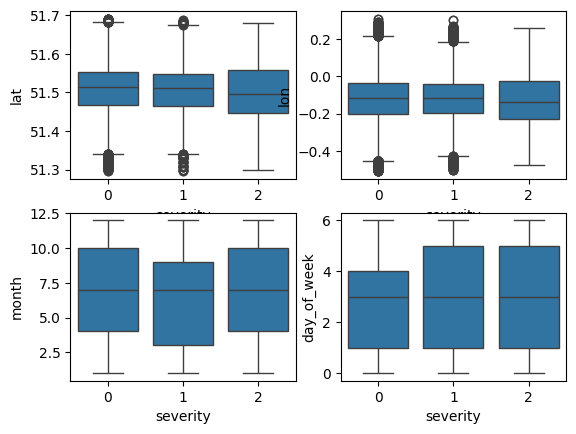

In [22]:
import seaborn as sns
from matplotlib import pyplot as plt

num_cols = ['lat', 'lon', 'month', 'day_of_week']
fig, ax = plt.subplots(nrows=2, ncols=2)

for i, col in enumerate(num_cols):
    sns.boxplot(x='severity', y=col, data=df_merged, ax=ax.flatten()[i])


In [23]:
df_merged.drop(columns=['id','date','casualty_age_0-23',
       'casualty_age_24-30', 'casualty_age_31-38', 'casualty_age_39-50',
       'casualty_age_50+', 'Car', 'Heavy_Vehicles', 'Motorcycle', 'Other',
       'Pedalcycle'], inplace=True)

In [24]:
from sklearn.model_selection import train_test_split

X = df_merged.drop(columns=['severity'])
y = df_merged['severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40500, 41)
(10126, 41)
(40500,)
(10126,)


Before using XGBoost as a classification model, it's good standardize numerical variables.

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [27]:
X_train.head()

,lat,lon,borough_Barking and Dagenham,borough_Barnet,borough_Bexley,borough_Brent,borough_Bromley,borough_Camden,borough_City of London,borough_City of Westminster,...,borough_Sutton,borough_Tower Hamlets,borough_Waltham Forest,borough_Wandsworth,time_of_day_Night,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening,month,day_of_week
6463,-0.987031,1.911563,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1.269732,0.045915
19662,1.133581,-1.718996,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-0.785355,1.084773
20686,1.050655,-1.526611,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,-0.198187,-0.473514
14861,0.181240,-2.119079,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0.095397,1.084773
20663,-0.341617,0.316850,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-0.198187,-0.992943


To handle the imbalance of out target class, we can exploit the sample_weight parameter of XGBClassifier.fit(). This is an example of **cost-sensitive learning**.

In [28]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import GridSearchCV
import numpy as np


random_state=42

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

model = XGBClassifier(random_state=random_state)
#param_grid={'max_depth': [2, 3, 4], 'n_estimators': list(range(20, 41, 5)), 'reg_lambda': np.linspace(0, 500, 6)}
#gscv = GridSearchCV(estimator=model, param_grid=param_grid)

model.fit(X_train, y_train, sample_weight=sample_weights)

#xbm, xbm_params = gscv.best_estimator_, gscv.best_params_


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [29]:
#print(xbm_params)

              precision    recall  f1-score   support

           0      0.919     0.742     0.821      8596
           1      0.300     0.624     0.405      1478
           2      0.261     0.577     0.359        52

    accuracy                          0.724     10126
   macro avg      0.493     0.647     0.528     10126
weighted avg      0.825     0.724     0.758     10126



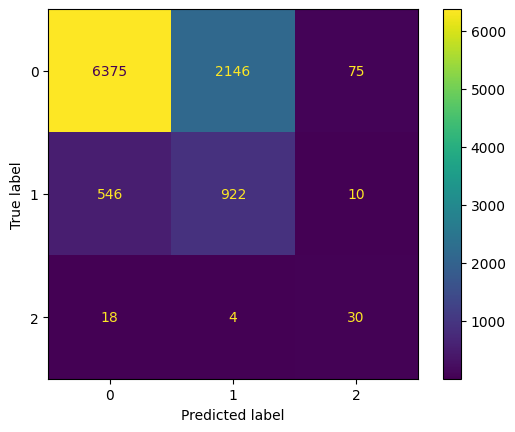

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

cm=confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

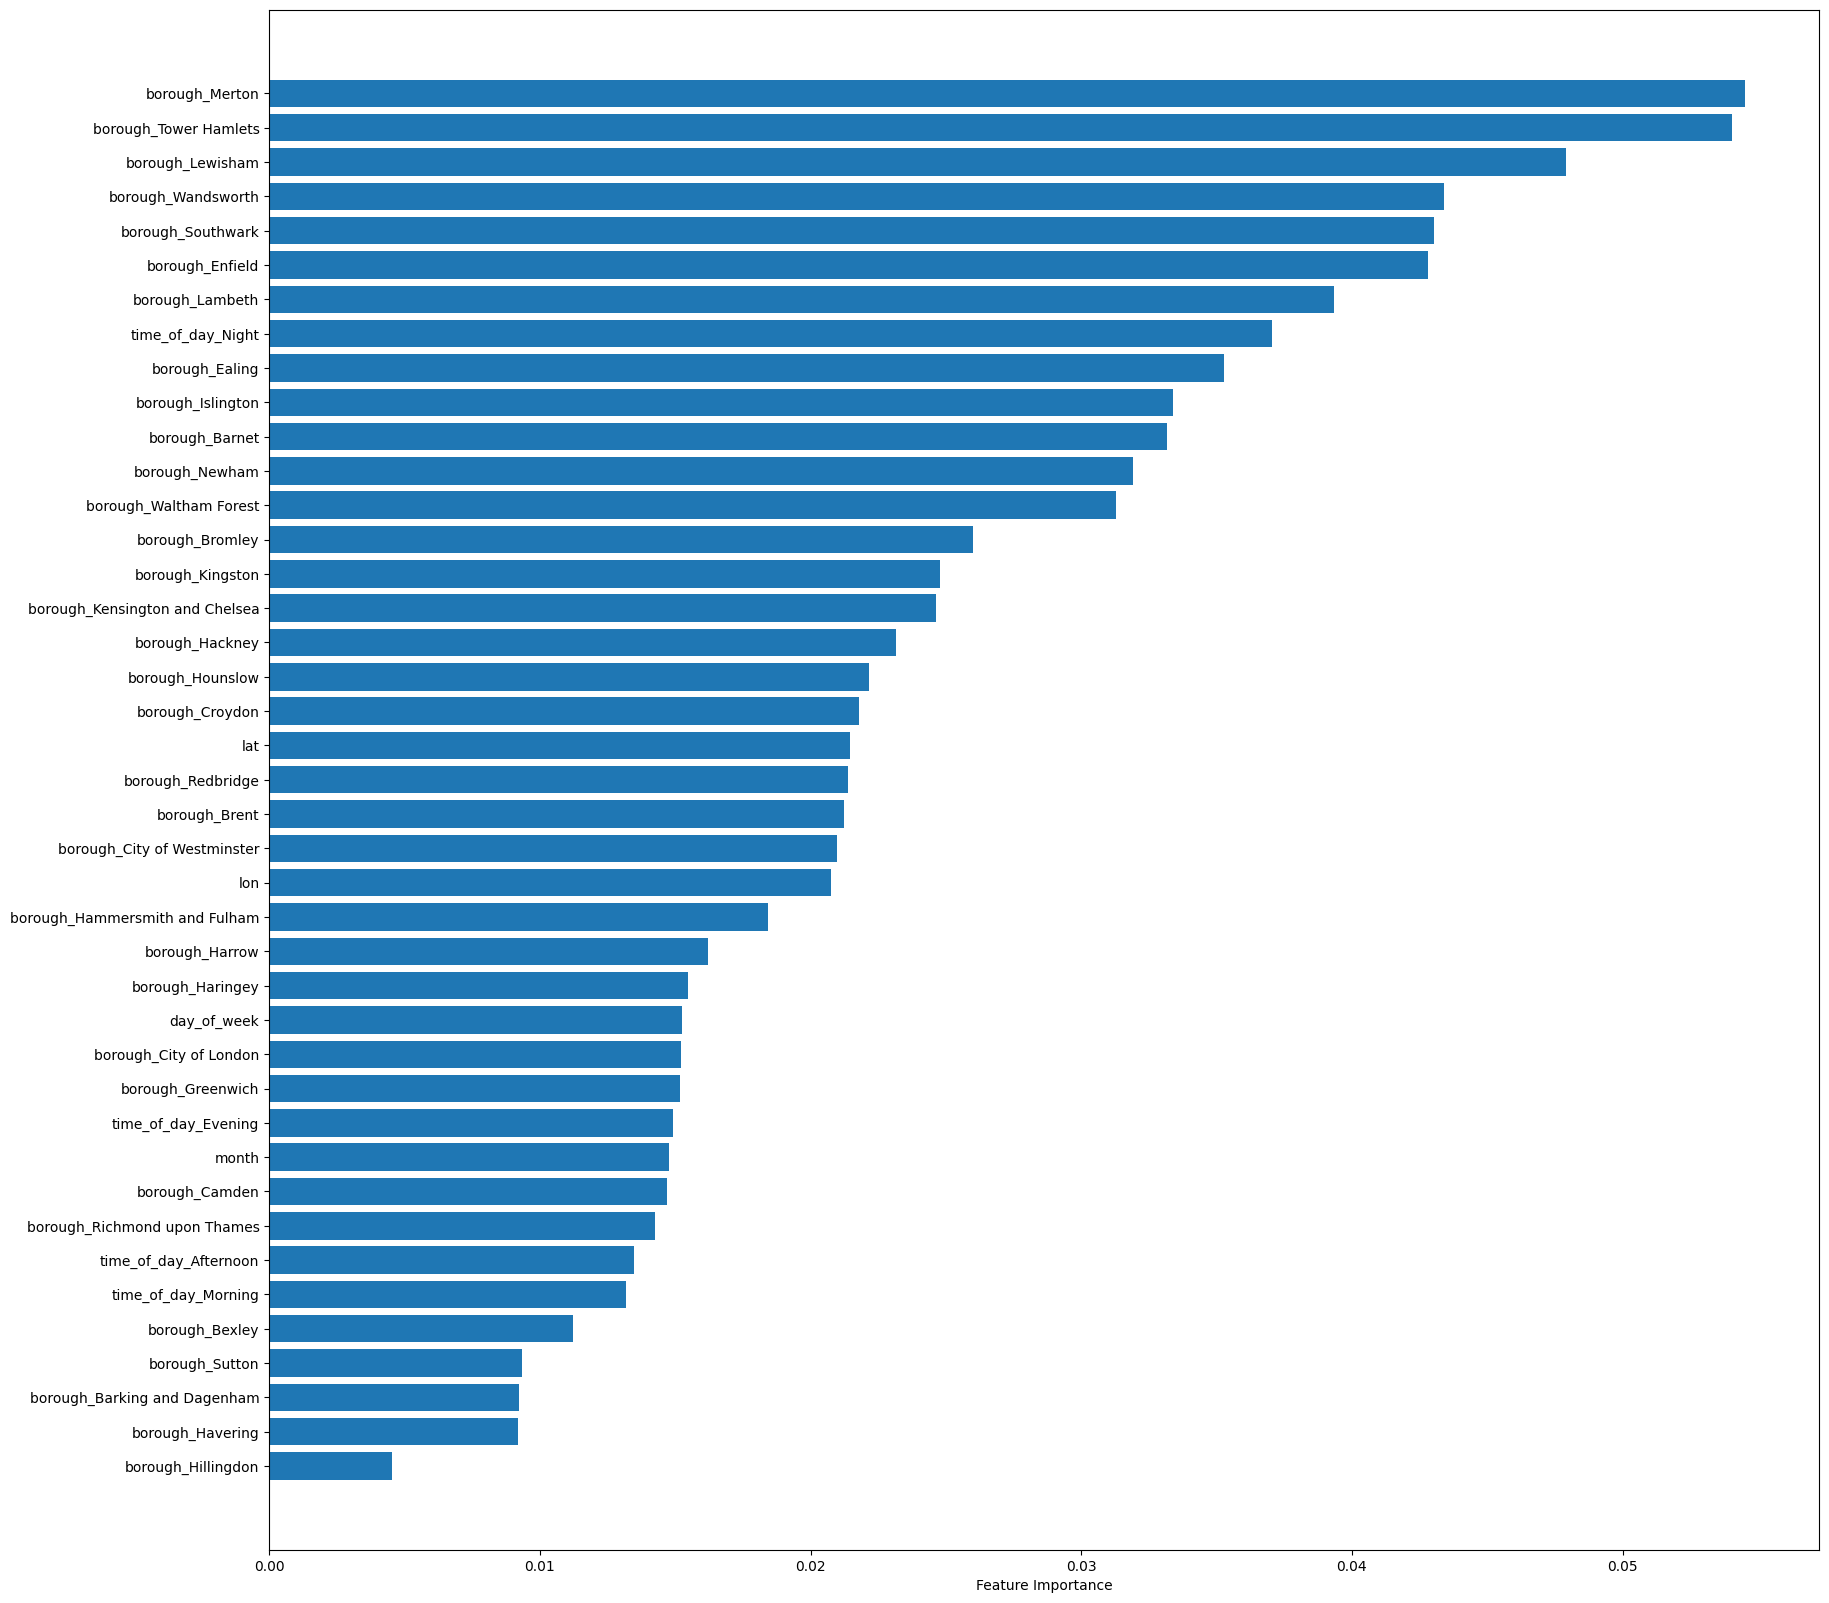

In [31]:

feature_importance = model.feature_importances_
plt.figure(figsize=(20,20))
sorted_idx = np.argsort(feature_importance)
plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.show()

In [34]:
from sklearn.inspection import permutation_importance

r_train = permutation_importance(model, X_train, y_train, n_repeats=30, random_state=42)
xbm_p_imp = pd.Series(index=X.columns, data=r_train.importances_mean)




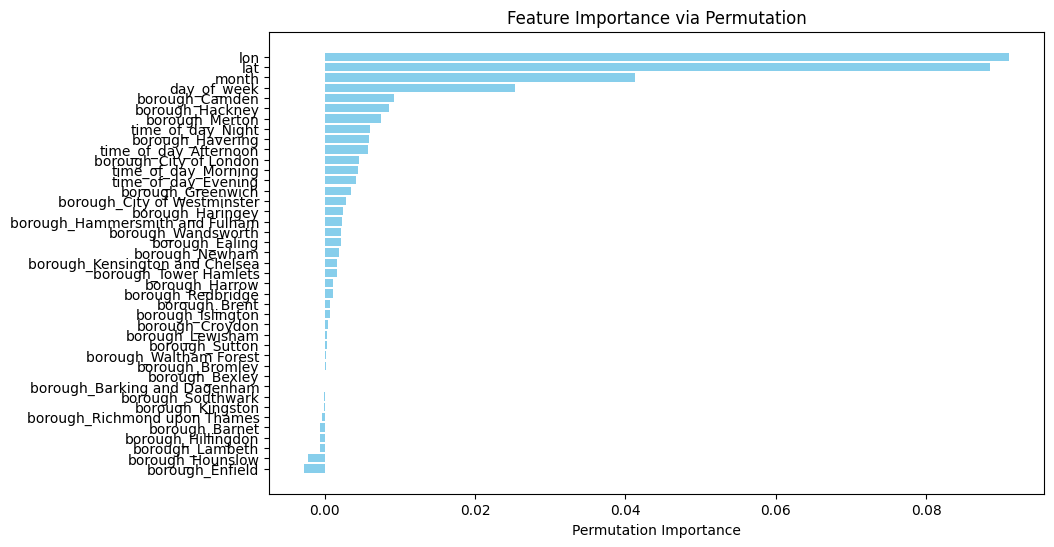

In [36]:
# Ordina le feature in base all'importanza media
sorted_idx = r_train.importances_mean.argsort()

# Crea il grafico
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns[sorted_idx], r_train.importances_mean[sorted_idx], color="skyblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance via Permutation")
plt.show()

# NOTES SECTION

## 3 OPTIONS:

* Forecasting
 * Determine out of the dataset what would happen
 * Predict accidents most likely
 * we could use past year data and compare directly with more recent data

* Corelating variables
 * Finding relationship betweetn different variables
 * expanding knowledge base to variables such as
 * Street direction, speed limit, street light, roundabout presence
 * tackle problems that normal statistics patterns or resarch can struggle with
 * Anomaly detection


* Optimization
 * Optimize the dataset
 * Most likely determining the best way to have the London transportation system
 * A simulation, hard to determine results




We could study what subjects are more at risk of severe accidents

What parts of the city are the most at risk

For insurance purposes


IDEA:
We could study the correlation between variables and accidents -> building a cost function to determine the reliability of a certain subject
Could be useful for INSURANCE COMPANIES